<a href="https://colab.research.google.com/github/ssoyyoungg/practice/blob/main/Teperature_scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#학습모델
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import random_split

classes = ('vehicle', 'animal')

def  binary_label(label):
  vehicle_classes = [0,1,8,9]
  return 0 if label in vehicle_classes else 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ✅ pretrained ResNet에 맞는 Normalize (최소 필수)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
train_dataset.targets = [binary_label(i) for i in train_dataset.targets]

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
test_dataset.targets = [binary_label(i) for i in test_dataset.targets]

# train dataset 80 : validation set 20 분리
train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset) - train_size

# 재현성 유지를 위해 seed 42로 고정
train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ CIFAR10용 ResNet18 패치
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 2) # 모델 2개 출력으로 변경
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
    return total_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

device: cuda


100%|██████████| 170M/170M [00:04<00:00, 39.3MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [2]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
print(type(train_dataset))
print(type(val_dataset))

40000
10000
10000
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


In [3]:
num_epoch = 10
for epoch in range(num_epoch):
    train_loss = train_one_epoch(model, train_loader)
    test_acc = evaluate(model, test_loader)
    val_acc = evaluate(model, val_loader)

    print(f"Epoch {epoch+1} |"
          f"Train Loss : {train_loss:.4f} |"
          f" Test Acc : {test_acc*100:.2f}% |"
          f"Val Acc: {val_acc:.2f}%")

Epoch 1 |Train Loss : 0.1724 | Test Acc : 96.12% |Val Acc: 0.96%
Epoch 2 |Train Loss : 0.0886 | Test Acc : 97.51% |Val Acc: 0.97%
Epoch 3 |Train Loss : 0.0651 | Test Acc : 97.59% |Val Acc: 0.98%
Epoch 4 |Train Loss : 0.0489 | Test Acc : 97.64% |Val Acc: 0.98%
Epoch 5 |Train Loss : 0.0438 | Test Acc : 98.11% |Val Acc: 0.98%
Epoch 6 |Train Loss : 0.0367 | Test Acc : 98.12% |Val Acc: 0.98%
Epoch 7 |Train Loss : 0.0317 | Test Acc : 98.10% |Val Acc: 0.98%
Epoch 8 |Train Loss : 0.0274 | Test Acc : 98.35% |Val Acc: 0.98%
Epoch 9 |Train Loss : 0.0272 | Test Acc : 98.36% |Val Acc: 0.98%
Epoch 10 |Train Loss : 0.0246 | Test Acc : 98.11% |Val Acc: 0.98%


Colibration 확인 방법 1 :

Reliability Diagram

In [4]:
# 예측확률(confidence(신뢰)) 수집 함수
# val/test 에서 softmax 확률(confidence) 뽑기
import torch
import numpy as np

def collect_confidences_and_correct(model, loader, device):
    model.eval()
    confs = []
    corrects = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            probs = torch.softmax(logits, dim=1)

            conf, pred = probs.max(dim=1)
            is_correct = (pred == labels).float()

            confs.append(conf.cpu())
            corrects.append(is_correct.cpu())

    confs = torch.cat(confs).numpy()
    corrects = torch.cat(corrects).numpy()

    return confs, corrects

bin별 통계 + ECE 계산

In [6]:
# confidence를 bin(10개의 구간)으로 나누고, 각 bin의 평균 confidence, 실제 accuracy 계산
def calibration_bins(confs, corrects, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confs, bins, right=True) - 1  # 0..n_bins-1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    bin_acc = np.zeros(n_bins, dtype=np.float64)
    bin_conf = np.zeros(n_bins, dtype=np.float64)
    bin_count = np.zeros(n_bins, dtype=np.int64)

    for b in range(n_bins):
        mask = (bin_ids == b)
        bin_count[b] = mask.sum()
        if bin_count[b] > 0:
            bin_acc[b] = corrects[mask].mean()
            bin_conf[b] = confs[mask].mean()
        else:
            bin_acc[b] = np.nan
            bin_conf[b] = np.nan

    # ECE (Expected Calibration Error)
    total = len(confs)
    ece = 0.0
    for b in range(n_bins):
        if bin_count[b] > 0:
            ece += (bin_count[b] / total) * abs(bin_acc[b] - bin_conf[b])

    return bins, bin_acc, bin_conf, bin_count, ece

Reliability Diagram 그리기

총 샘플 수: 10000
bin_count 합: 10000
유효 bin 개수: 5


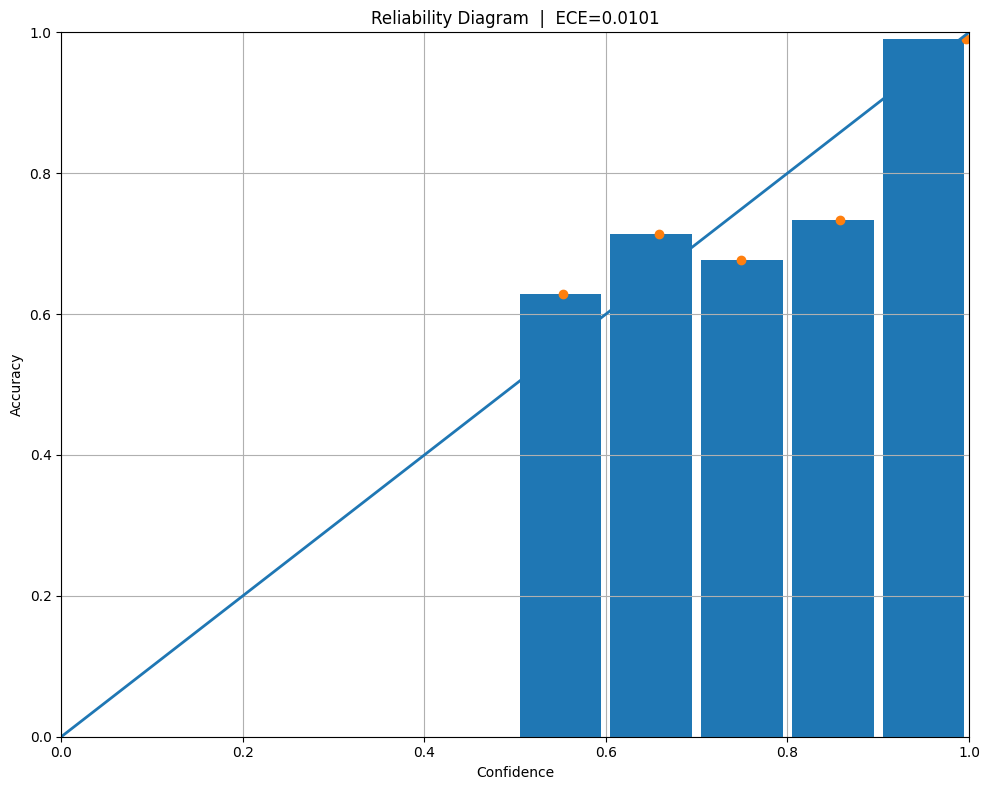

In [7]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt


def plot_reliability_diagram(bins, bin_acc, bin_conf, bin_count, ece, title="Reliability Diagram"):
    centers = (bins[:-1] + bins[1:]) / 2
    width = (bins[1] - bins[0]) * 0.9

    mask = ~np.isnan(bin_acc)
    if mask.sum() == 0:
        print("유효한 bin이 없어요. (bin_acc가 전부 NaN) confs/corrects 생성이나 binning을 확인하세요.")
        return

    plt.figure(figsize=(10,8))
    plt.bar(centers[mask], bin_acc[mask], width=width, align='center')
    plt.plot([0, 1], [0, 1], linewidth=2)
    plt.scatter(bin_conf[mask], bin_acc[mask])

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title(f"{title}  |  ECE={ece:.4f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# confidence 수집
confs, corrects = collect_confidences_and_correct(model, val_loader, device)

# bin 통계 + ECE 계산
bins, bin_acc, bin_conf, bin_count, ece = calibration_bins(confs, corrects, n_bins=10)

# 디버깅용 출력
print("총 샘플 수:", len(confs))
print("bin_count 합:", bin_count.sum())
print("유효 bin 개수:", (~np.isnan(bin_acc)).sum())

# 3️⃣ 그래프 그리기
plot_reliability_diagram(bins, bin_acc, bin_conf, bin_count, ece)



Temperature Scaling

In [8]:
#Temperature Scaling 클래스 만들기
import torch
import torch.nn as nn
import torch.optim as optim

class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def forward(self, x):
        logits = self.model(x)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        return logits / self.temperature

Temperature 학습 (Validation 데이터 사용)

In [9]:
def set_temperature(model, valid_loader, device):
    model.eval()
    nll_criterion = nn.CrossEntropyLoss().to(device)

    logits_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            logits_list.append(logits)
            labels_list.append(labels)

    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    temperature = nn.Parameter(torch.ones(1).to(device))
    optimizer = optim.LBFGS([temperature], lr=0.01, max_iter=50)

    def eval():
        optimizer.zero_grad()
        loss = nll_criterion(logits / temperature, labels)
        loss.backward()
        return loss

    optimizer.step(eval)

    print("최적 Temperature:", temperature.item())
    return temperature

전 / 후 ECE 계산

In [10]:
confs, corrects = collect_confidences_and_correct(model, val_loader, device)
bins, bin_acc, bin_conf, bin_count, ece_before = calibration_bins(confs, corrects)

print("Temperature 적용 전 ECE:", ece_before)

Temperature 적용 전 ECE: 0.008866713517904282


Temperature 적용 후

In [11]:
T = set_temperature(model, val_loader, device)

def collect_conf_temp(model, loader, device, T):
    model.eval()
    confs = []
    corrects = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images) / T
            probs = torch.softmax(logits, dim=1)

            conf, pred = probs.max(dim=1)
            is_correct = (pred == labels).float()

            confs.append(conf.cpu())
            corrects.append(is_correct.cpu())

    confs = torch.cat(confs).numpy()
    corrects = torch.cat(corrects).numpy()
    return confs, corrects

confs_T, corrects_T = collect_conf_temp(model, val_loader, device, T)
bins_T, bin_acc_T, bin_conf_T, bin_count_T, ece_after = calibration_bins(confs_T, corrects_T)

print("Temperature 적용 후 ECE:", ece_after)

최적 Temperature: 1.1194566488265991
Temperature 적용 후 ECE: 0.006803925102949143


Temperature 적용 후 ECE 감소함

적용 전 / 적용 후 그래프 비교

<Figure size 1600x600 with 0 Axes>

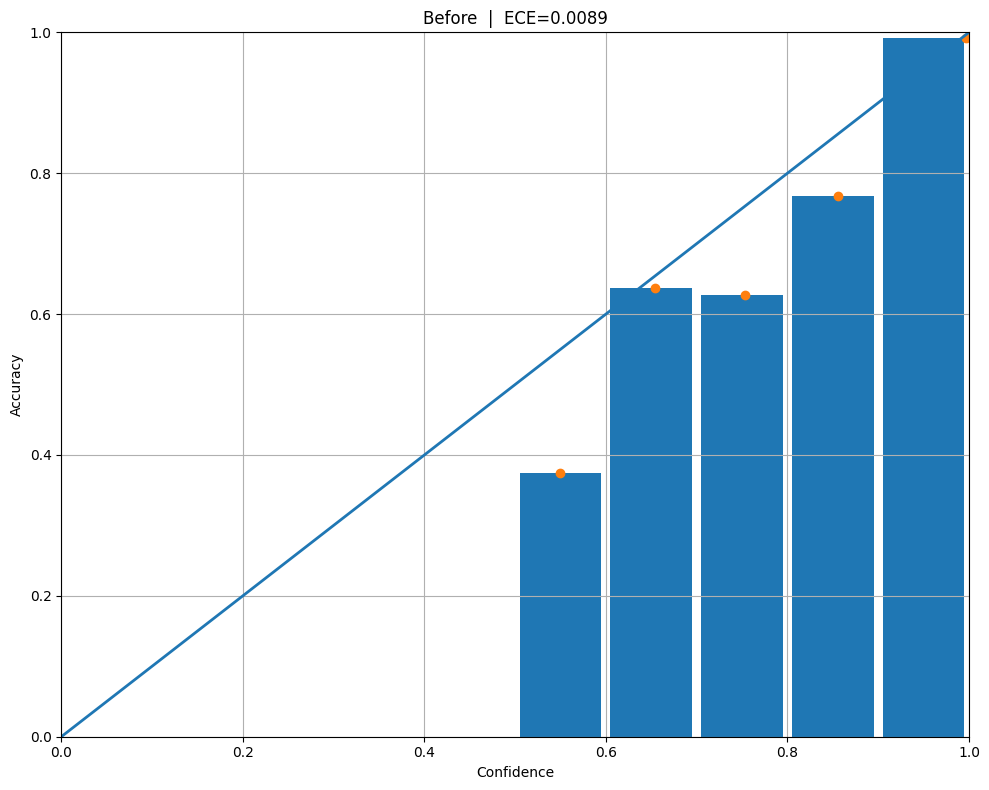

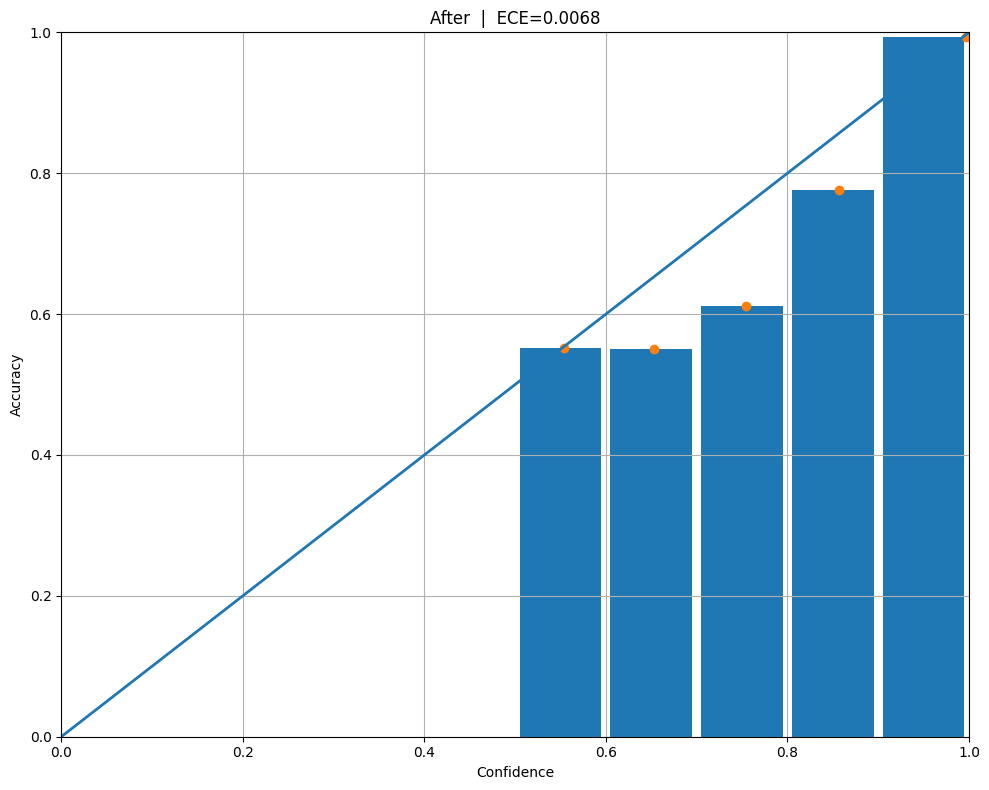

In [13]:
plt.figure(figsize=(16,6))

plot_reliability_diagram(bins, bin_acc, bin_conf, bin_count, ece_before, title="Before")
plot_reliability_diagram(bins_T, bin_acc_T, bin_conf_T, bin_count_T, ece_after, title="After")